<a href="https://colab.research.google.com/github/frasercrichton/fastai2-learning/blob/master/nbs/drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drone Tutorial

## Setup the Virtual Machine
 


Install stuff . . .

In [1]:
%matplotlib inline
bs = 64     # default batch size
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fastai2 -q
!pip install utils
from utils import *
from fastai2.vision.all import *

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0   7255      0 --:--:-- --:--:-- --:--:--  7255
OK
60 packages can be upgraded. Run 'apt list --upgradable' to see them.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 184kB 4.5MB/s 


## Data

All the images to running training on are held in GCP. This bit connects to the GCP Bucket and mounts it so we can use it.

In [3]:
from google.colab import auth
auth.authenticate_user()

In [7]:
!rm -rf "data" 
!mkdir "data"
!rm -rf "download" 
!mkdir "download"
project_id = "forensic-265906"
!gcloud config set project {project_id}
!gsutil -m cp -r gs://forensic-architecture-machine-learning/drones/drones.zip download/drones.zip

Updated property [core/project].
Copying gs://forensic-architecture-machine-learning/drones/drones.zip...
/ [1/1 files][  1.8 MiB/  1.8 MiB] 100% Done                                    
Operation completed over 1 objects/1.8 MiB.                                      


In [8]:
!rm -rf "data" 
!unzip "download/drones.zip"

Archive:  download/drones.zip
   creating: data/drones/
  inflating: data/drones/.DS_Store   
   creating: data/drones/dataset/
  inflating: data/drones/dataset/Maveric.log  
  inflating: data/drones/dataset/RQ-7_Shadow.log  
 extracting: data/drones/dataset/RQ-170_Sentinel.log  
  inflating: data/drones/dataset/MQ-19_Aerosonde.log  
  inflating: data/drones/dataset/MQ-1_Predator.log  
  inflating: data/drones/dataset/Snipe.log  
   creating: data/drones/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/
  inflating: data/drones/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/.DS_Store  
  inflating: data/drones/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000020.jpg  
  inflating: data/drones/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000008.jpg  
  inflating: data/drones/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000009.jpg  
  inflating: data/drones/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000007.jpg  
  inflating: data/drones/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000012.jpg  
  inflating: data/drones/d

Get that dataset

In [18]:
path = Path("data/drones"); path

Path('data/drones')

In [19]:
Path.BASE_PATH = path # display all paths relative to dataset root
path.ls()

(#2) [Path('dataset'),Path('.DS_Store')]

In [20]:
path_img = path/'dataset'
fnames = get_image_files(path_img)
fnames

(#247) [Path('dataset/RQ-11_Raven/000048.jpg'),Path('dataset/RQ-11_Raven/000011.jpg'),Path('dataset/RQ-11_Raven/000005.jpg'),Path('dataset/RQ-11_Raven/000030.jpg'),Path('dataset/RQ-11_Raven/000001.jpg'),Path('dataset/RQ-11_Raven/000009.jpg'),Path('dataset/RQ-11_Raven/000003.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000067.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000066.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000079.jpg')...]

Populate an Image data loader and then check we can see some drones in there.

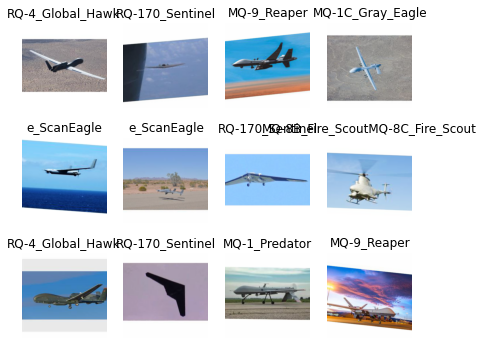

In [21]:

def label_func(x): return x.parent.name


dls = ImageDataLoaders.from_path_func(path_img, fnames, label_func,
                                      item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=bs//2,
                                     batch_tfms=[*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)])
# , item_tfms=Resize(460), bs=bs, batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
dls.show_batch(max_n=12, figsize=(7,6))

In [22]:
print(dls.vocab)
len(dls.vocab),dls.c

(#14) ['MQ-19_Aerosonde','MQ-1C_Gray_Eagle','MQ-1_Predator','MQ-8B_Fire_ScoutMQ-8C_Fire_Scout','MQ-9_Reaper','RQ-11_Raven','RQ-12_Wasp','RQ-170_Sentinel','RQ-20_Puma','RQ-21_Blackjack'...]


(14, 14)


## Images 

The images for the project are held in Google Drive and can be mounted below.

In [23]:
path_img = path/'dataset'
fnames = get_image_files(path_img)
fnames

(#247) [Path('dataset/RQ-11_Raven/000048.jpg'),Path('dataset/RQ-11_Raven/000011.jpg'),Path('dataset/RQ-11_Raven/000005.jpg'),Path('dataset/RQ-11_Raven/000030.jpg'),Path('dataset/RQ-11_Raven/000001.jpg'),Path('dataset/RQ-11_Raven/000009.jpg'),Path('dataset/RQ-11_Raven/000003.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000067.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000066.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000079.jpg')...]

Train that model. 

In [24]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fit_one_cycle(10)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,4.155322,3.334039,1.000000,00:06
1,3.848787,2.834369,0.897959,00:02
2,3.300589,2.098944,0.653061,00:02
3,2.728793,1.976867,0.551020,00:02
4,2.256463,1.847276,0.489796,00:02
5,1.906596,1.765954,0.489796,00:02
6,1.638638,1.670731,0.428571,00:02
7,1.418895,1.643638,0.408163,00:02
8,1.237297,1.632664,0.408163,00:02
9,1.103824,1.645137,0.408163,00:02


In [25]:
learn.save('stage-1')

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

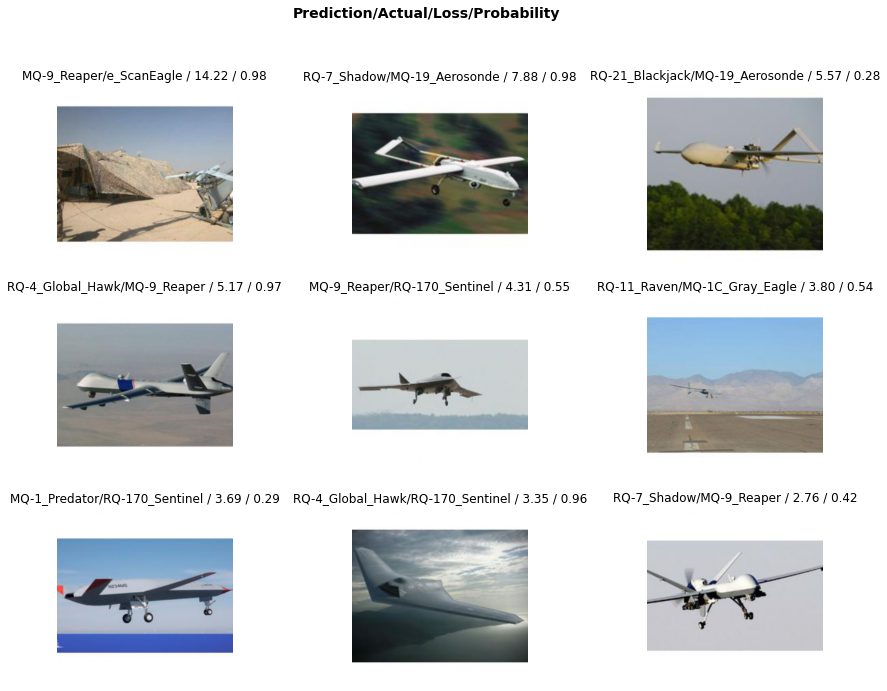

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

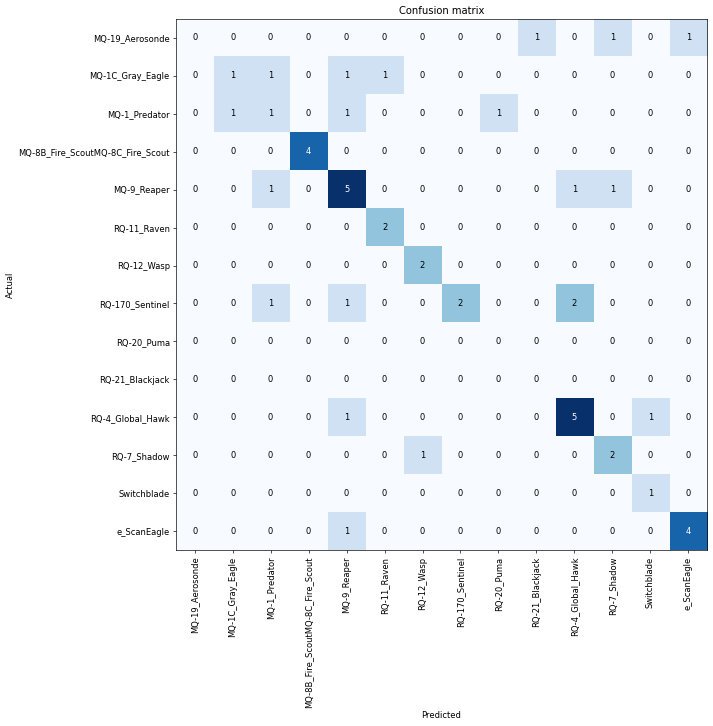

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

And everything appears confused for now:

In [29]:
interp.most_confused(min_val=2)

[('RQ-170_Sentinel', 'RQ-4_Global_Hawk', 2)]